# Binary Classification: are this two documents from the same desafio?

Objectivos:

        Comparar LSA con el anterior ganador: Transformers Sentence Embedding

### Preprocess

In [5]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *

from MyModule.TopicModelingFunctinos import *

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [6]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [7]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

pp = Preprocess()
df['prepro_text'] = pp.preprocess(df['texto'])

df.reset_index(inplace=True, drop=True)

### Create target variable: 
True if the pair comes from the same desafio, false otherwise

In [8]:
# Create a list of tuples containing all possible pairs of strings and ID's
import itertools
id_pairs = list(itertools.combinations(df['ID'].values, 2))

In [9]:
# Create target: 1 if both ID's are from the same desafio, 0 otherwise
target = []
for id1, id2 in id_pairs:
    for desafio in df['desafio'].unique():
        ids_desafio = df[df['desafio']==desafio]['ID'].values
        if id1 in ids_desafio and id2 in ids_desafio:
            target.append(1)
            break
        elif id1 in ids_desafio or id2 in ids_desafio:
            target.append(0)
            break

In [10]:
df_predic = pd.DataFrame([id_pairs, target]).T
df_predic.columns = ['id_pairs','target']

# Are this two ideas from the same desafio?

## Sentence embedding feature

Create a sentence embedding for each document using LSA/LDA

In [11]:
# Define data and model
documents = df['prepro_text'].values.tolist()

In [12]:
n_components = 300

# Create the TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# fit Model
model = TruncatedSVD(n_components=n_components)
lsa_matrix = model.fit_transform(X)

# Normalize the matrix
normalizer = Normalizer(copy=False)
lsa_matrix = normalizer.fit_transform(lsa_matrix)

In [13]:
# Add as featrues the document vectors for each document in the pair

first_doc_emb = []
second_doc_emb = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    indice_pair1 = df[df['ID']==pair1].index[0]
    first_doc_emb.append(lsa_matrix[indice_pair1])
    
    indice_pair2 = df[df['ID']==pair2].index[0]
    second_doc_emb.append(lsa_matrix[indice_pair2])
    

# create dataframe
df_emb_1 = pd.DataFrame(first_doc_emb)
df_emb_2 = pd.DataFrame(second_doc_emb)

# rename columns
df_emb_1.columns = [f'first_doc_emb_dim_{i+1}' for i in range(len(first_doc_emb[0]))]
df_emb_2.columns = [f'second_doc_emb_dim_{i+1}' for i in range(len(second_doc_emb[0]))]
df_emb = df_emb_1.join(df_emb_2)

# join with main df
df_predic = df_predic.join(df_emb)

## Sentiment Analysis feature

Evaluate positive, negative and neutral sentiment for each document

In [14]:
# Analyze the three sentiments for each doc
from MyModule.SentimentAnalysisFunctions import sentiment_analyzer_3d

all_emotions = {}
analyzer = sentiment_analyzer_3d()

for i, this_id in enumerate(df['ID'].values):
    all_emotions[this_id] = analyzer.predict_sentiment_3d(df['texto'].values.tolist()[i])

In [15]:
# Add as featrues the document vectors for each document in the pair

first_doc_pos = []
first_doc_neg = []
first_doc_neu = []

second_doc_pos = []
second_doc_neg = []
second_doc_neu = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_pos.append(all_emotions[pair1][0])
    first_doc_neg.append(all_emotions[pair1][1])
    first_doc_neu.append(all_emotions[pair1][2])
    
    second_doc_pos.append(all_emotions[pair2][0])
    second_doc_neg.append(all_emotions[pair2][1])
    second_doc_neu.append(all_emotions[pair2][2])
    

df_predic['first_doc_pos'] = first_doc_pos
df_predic['first_doc_neg'] = first_doc_neg
df_predic['first_doc_neu'] = first_doc_neu

df_predic['second_doc_pos'] = second_doc_pos
df_predic['second_doc_neg'] = second_doc_neg
df_predic['second_doc_neu'] = second_doc_neu


## Document's Length Feature

Compute document length 

In [16]:
all_lengths = {}

for i, this_id in enumerate(df['ID'].values):
    all_lengths[this_id] = len(df['texto'][i].split(' '))

In [17]:
first_doc_len = []
second_doc_len = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_len.append(all_lengths[pair1])
    second_doc_len.append(all_lengths[pair2])

df_predic['first_doc_len'] = first_doc_len
df_predic['second_doc_len'] = second_doc_len

In [18]:
#checkpoint
# df_predic.to_csv('df_predic.csv', index=False)

# Modeling

In [19]:
semilla = 2023

In [20]:
# Helpers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def print_performance(y_test, y_pred, y_proba=None):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    
    # ROC
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    print('AUC: %f' % logit_roc_auc)
    
    try:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
        
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
    except:
        pass
    

import pickle
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename): 
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [21]:
# Load dfs
df_predic = pd.read_csv('df_predic.csv')
df_predic['id_pairs'] = df_predic['id_pairs'].apply(lambda x: string_to_tuple(x)) # recovering tuples

### Scaling

Since features have different scales

In [22]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

# Instanciamos la funcion para escalar
scaler = StandardScaler()

#Escalamos las variables
scaled = scaler.fit_transform(df_predic.drop(['id_pairs','target'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])
df_predic_scaled = df_predic_scaled.join(df_predic[['id_pairs','target']])

### Train-test split

80% train

In [23]:
from sklearn.model_selection import train_test_split

# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target'].drop('id_pairs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

### Balanceo de clases SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=semilla)

In [25]:
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

In [26]:
print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of 1",len(os_data_y[os_data_y['target']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

length of oversampled data is  173982
Number of 0 in oversampled data 86991
Number of 1 86991
Proportion of 0 data in oversampled data is  0.5
Proportion of 1 data in oversampled data is  0.5


### Balanceo de clases: subsampleo de clase mayoritaria

In [27]:
train = X_train
train['target'] = y_train

positivos = train[train.target == 1]
negativos = train[train.target == 0]

negativos_sub = negativos.sample(n=len(positivos), random_state=semilla)

train_sub = pd.concat([positivos, negativos_sub])

y_train = train_sub.loc[:, train_sub.columns == 'target']
X_train = train_sub.loc[:, train_sub.columns != 'target']
print(len(positivos), len(negativos_sub))

14817 14817


## 1. Logistic Regression

### Simple Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000, fit_intercept=True)

# entrenamiento
logisticRegr.fit(X_train, y_train)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
# Claramente las clases estan desbalanceadas
targets = df_predic_scaled['target'].value_counts()
print(f'Percentage of class 0: {targets[0]/sum(targets)}')
print_performance(y_test, y_pred)

Percentage of class 0: 0.8544397296872545
Accuracy: 0.521688
Precision: 0.169387
Recall: 0.585109
F1 score: 0.262718
AUC: 0.547993


### Logistic Regression with balanced classes

In [31]:
# entrenamiento
logisticRegr.fit(os_data_X, os_data_y)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
print_performance(y_test, y_pred)

Accuracy: 0.573354
Precision: 0.170354
Recall: 0.498516
F1 score: 0.253933
AUC: 0.542314


## 2. SGDClassifier

In [33]:
#Importamos el modelo y algunas funciones auxiliares
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

from sklearn.linear_model import  SGDClassifier

In [34]:
sgd_classifier = SGDClassifier()

In [35]:
# Definimos los parametros
sgd_parametros={'loss': ['hinge','log_loss','modified_hube','squared_hinge','perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet', None],
             'alpha': loguniform(1e-4, 1e0),
             'l1_ratio':stats.uniform(0, 1)
        }

In [36]:
#Ajustamos el modelo
cv = 3
n_iteraciones = 20

sgd_classifier = SGDClassifier()
sgd_random_search = RandomizedSearchCV(estimator=sgd_classifier, n_iter = n_iteraciones, param_distributions = sgd_parametros,
                                   cv = cv, scoring ='accuracy', random_state = semilla )
sgd_random_search.fit(X_train, y_train)

print('Mejor combinación de parámetros %s \n'% sgd_random_search.best_params_)
print('Definición del Modelo %s \n'% sgd_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% sgd_random_search)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Mejor combinación de parámetros {'alpha': 0.00999550089604053, 'l1_ratio': 0.3642569891908011, 'loss': 'hinge', 'penalty': 'l2'} 

Definición del Modelo SGDClassifier(alpha=0.00999550089604053, l1_ratio=0.3642569891908011) 

Combinaciones Evaluadas RandomizedSearchCV(cv=3, estimator=SGDClassifier(), n_iter=20,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020D04CDB040>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020C80F31B80>,
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_hube',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    None]},
         

In [37]:
y_pred = sgd_random_search.best_estimator_.predict(X_test)
print_performance(y_test, y_pred)

Accuracy: 0.523967
Precision: 0.188117
Recall: 0.684111
F1 score: 0.295090
AUC: 0.590389


## 3. KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [39]:
# instanciemos y entrenemos el modelo
knn_model = KNeighborsClassifier(n_neighbors=10,weights='uniform')
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)
print_performance(y_test, y_pred)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.785518
Precision: 0.391825
Recall: 0.855948
F1 score: 0.537569
AUC: 0.814730


In [40]:
# Definimos los parametros
knn_parametros={'n_neighbors':list(range(1, 20)),
                'weights':['uniform', 'distance'],
                'metric':['euclidean', 'chebyshev', 'manhattan']
        }

In [41]:
#Ajustamos el modelo
cv = 3

knn_classifier = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_classifier, param_grid = knn_parametros,
                                   cv=cv, scoring ='accuracy')
knn_grid_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'chebyshev', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [42]:
print('Mejor combinación de parámetros %s \n'% knn_grid_search.best_params_)
print('Definición del Modelo %s \n'% knn_grid_search.best_estimator_)

Mejor combinación de parámetros {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} 

Definición del Modelo KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') 



Accuracy: 0.795419
Precision: 0.407567
Recall: 0.892096
F1 score: 0.559513
AUC: 0.835517


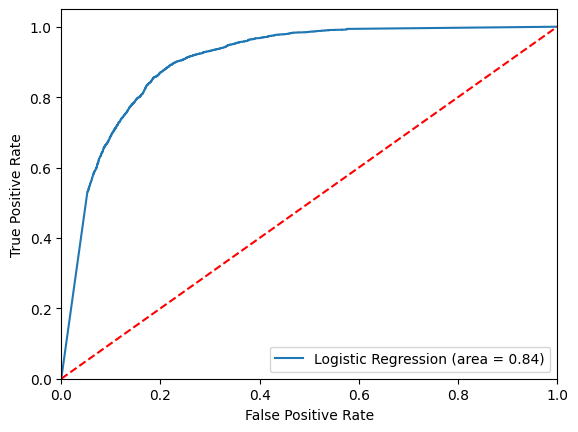

In [43]:
y_pred = knn_grid_search.predict(X_test)
y_pred_proba = knn_grid_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 4. DecisionTree

### 4.a Simple DecisionTree

In [44]:
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_train,y_train)

y_pred = arbol.predict(X_test)
print_performance(y_test, y_pred)

Accuracy: 0.432068
Precision: 0.161885
Recall: 0.694092
F1 score: 0.262538
AUC: 0.540746


In [45]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]

C:\Users\Felipe\AppData\Local\Temp\ipykernel_14424\3721313899.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]


### 4.b DecisionTree hyperparameter opt

In [48]:
dt_parameters = {
    'max_depth' : [1, 2, 3, 10, 30, 100],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    'max_leaf_nodes':list(range(10, 60))
}

n_iter = 40
cv = 3

dt_tree = DecisionTreeClassifier()

dt_grid_search = RandomizedSearchCV(estimator=dt_tree, 
                                         param_distributions=dt_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

dt_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=48, min_samples_leaf=30, min_samples_split=19; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=48, min_samples_leaf=30, min_samples_split=19; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=48, min_samples_leaf=30, min_samples_split=19; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=28, min_samples_split=35; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=28, min_samples_split=35; total time=   0.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=40, min_samples_leaf=28, min_samples_split=35; total time=   0.3s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=18, min_samples_leaf=2, min_samples_split=13; total time=   0.2s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=18, min_samples_leaf=2, min_samples_split=13; total time=   0.1s
[CV] END max_depth=100, max_features=log2, max_leaf_nodes=18, min_samples_leaf=2, min_samples_split=13; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=34, min_samples_leaf=37, min_samples_split=13; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=34, min_samples_leaf=37, min_samples_split=13; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=34, min_samples_leaf=37, min_samples_split=13; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=17, min_samples_leaf=38, min_samples_split=36; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=17, min_samples_leaf=38, min_samples_split=36; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=17, min_samples_leaf=38, min_samples_split=36; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=57, min_samples_leaf=10, min_samples_split=28; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=57, min_samples_leaf=10, min_samples_split=28; total time=   0.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=100, max_features=auto, max_leaf_nodes=57, min_samples_leaf=10, min_samples_split=28; total time=   0.3s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=34, min_samples_split=37; total time=   0.2s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=34, min_samples_split=37; total time=   0.2s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=34, min_samples_split=37; total time=   0.2s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=51, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=51, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=51, min_samples_leaf=4, min_samples_split=7; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, max_leaf_nodes=51, min_samples_leaf=23, min_samples_split=38; total time=   0.2s
[CV] END max_depth=3, max_fe

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=57, min_samples_leaf=23, min_samples_split=29; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=57, min_samples_leaf=23, min_samples_split=29; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=57, min_samples_leaf=23, min_samples_split=29; total time=   0.3s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=11, min_samples_leaf=23, min_samples_split=39; total time=   0.0s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=11, min_samples_leaf=23, min_samples_split=39; total time=   0.0s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=11, min_samples_leaf=23, min_samples_split=39; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=39, min_samples_leaf=6, min_samples_split=34; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=39, min_samples_leaf=6, min_samples_split=34; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=39, min_samples_leaf=6, min_samples_split=34; total time=   0.3s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=26, min_samples_leaf=5, min_samples_split=31; total time=   0.0s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=26, min_samples_leaf=5, min_samples_split=31; total time=   0.0s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=26, min_samples_leaf=5, min_samples_split=31; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=52, min_samples_leaf=39, min_samples_split=24; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=52, min_samples_leaf=39, min_samples_split=24; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=52, min_samples_leaf=39, min_samples_split=24; total time=   0.3s
[CV] END max_depth=100, max_features=None, max_leaf_nodes=59, min_samples_leaf=30, min_samples_split=39; total time=   0.0s
[CV] END max_depth=100

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=2, max_features=auto, max_leaf_nodes=59, min_samples_leaf=16, min_samples_split=29; total time=   0.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=2, max_features=auto, max_leaf_nodes=59, min_samples_leaf=16, min_samples_split=29; total time=   0.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=2, max_features=auto, max_leaf_nodes=59, min_samples_leaf=16, min_samples_split=29; total time=   0.2s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=51, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=51, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END max_depth=10, max_features=None, max_leaf_nodes=51, min_samples_leaf=14, min_samples_split=17; total time=   0.0s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=17, min_samples_leaf=30, min_samples_split=18; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=17, min_samples_leaf=30, min_samples_split=18; total time=   0.1s
[CV] END max_depth=2, max_features=log2, max_leaf_nodes=17, min_samples_leaf=30, min_samples_split=18; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=2; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=2; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, max_leaf_nodes=50, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=25, min_samples_leaf=24, min_samples_split=14; total time=   0.3s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=25, min_samples_leaf=24, min_samples_split=14; total time=   0.3s
[CV] END max_depth=100, max_features=sqrt, max_leaf_nodes=25, min_samples_leaf=24, min_samples_split=14; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=37, min_samples_leaf=32, min_samples_split=6; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=37, min_samples_leaf=32, min_samples_split=6; total time=   0.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, max_leaf_nodes=37, min_samples_leaf=32, min_samples_split=6; total time=   0.3s
[CV] END max_depth=30, max_features=log2, max_leaf_nodes=47, min_samples_leaf=8, min_samples_split=18; total time=   0.2s
[CV] END max_depth=30, max_features=log2, max_leaf_nodes=47, min_samples_leaf=8, min_samples_split=18; total time=   0.1s
[CV] END max_depth=30, max_features=log2, max_leaf_nodes=47, min_samples_leaf=8, min_samples_split=18; total time=   0.2s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=43, min_samples_leaf=37, min_samples_split=4; total time=   0.0s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=43, min_samples_leaf=37, min_samples_split=4; total time=   0.0s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=43, min_samples_leaf=37, min_samples_split=4; total time=   0.0s
[CV] END max_depth=2, max_features=None, max_leaf_nodes=19, min_samples_leaf=31, min_samples_split=22; total time=   0.0s
[CV] END max_depth=2, max_f

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=52, min_samples_leaf=26, min_samples_split=9; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=52, min_samples_leaf=26, min_samples_split=9; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=52, min_samples_leaf=26, min_samples_split=9; total time=   0.1s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=59, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=59, min_samples_leaf=10, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=None, max_leaf_nodes=59, min_samples_leaf=10, min_samples_split=5; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=54, min_samples_leaf=17, min_samples_split=26; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=54, min_samples_leaf=17, min_samples_split=26; total time=   0.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV] END max_depth=1, max_features=auto, max_leaf_nodes=54, min_samples_leaf=17, min_samples_split=26; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=42, min_samples_leaf=37, min_samples_split=18; total time=   0.2s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=42, min_samples_leaf=37, min_samples_split=18; total time=   0.1s
[CV] END max_depth=2, max_features=sqrt, max_leaf_nodes=42, min_samples_leaf=37, min_samples_split=18; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=4, min_samples_split=10; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=4, min_samples_split=10; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=4, min_samples_split=10; total time=   0.3s
[CV] END max_depth=1, max_features=None, max_leaf_nodes=19, min_samples_leaf=28, min_samples_split=4; total time=   0.0s
[CV] END max_depth=1, max

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
33 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\tree\_classes.py", line 177, in fit
    self._validate_params()
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=40,
                   param_distributions={'max_depth': [1, 2, 3, 10, 30, 100],
                                        'max_features': ['None', 'auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...]},
                   scoring='accuracy', verbose=2)

In [49]:
# This suggests overfitting
print('train accuracy:',dt_grid_search.best_score_, dt_grid_search.best_params_, '\n')

y_pred = dt_grid_search.predict(X_test)
print_performance(y_test, y_pred)

train accuracy: 0.640143078895863 {'min_samples_split': 28, 'min_samples_leaf': 10, 'max_leaf_nodes': 57, 'max_features': 'auto', 'max_depth': 100} 

Accuracy: 0.522827
Precision: 0.204096
Recall: 0.785001
F1 score: 0.323963
AUC: 0.631567


## 5. RandomForestClassifier

### 5.a Simple RandomForestClassifier

C:\Users\Felipe\AppData\Local\Temp\ipykernel_14424\2651474788.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train,y_train)


Accuracy: 0.903112
Precision: 0.604796
Recall: 0.966010
F1 score: 0.743872
AUC: 0.929200


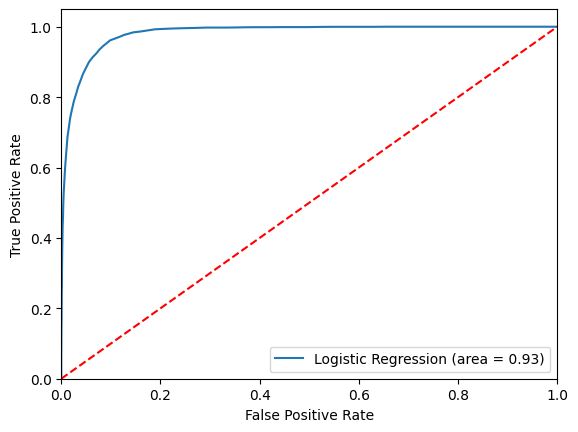

In [50]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 5.b RandomForestClassifier hyperparameter opt

In [51]:
rf_parameters = {
    'n_estimators':range(10,500),
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth' : [30, 100, 150, 250, 350, 550],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    # 'max_leaf_nodes':list(range(10, 100))
}

n_iter = 100
cv = 3

rf_tree = RandomForestClassifier()

rf_randomized_search = RandomizedSearchCV(estimator=rf_tree, 
                                         param_distributions=rf_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=sqrt, min_samples_leaf=22, min_samples_split=14, n_estimators=332; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  58.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  58.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=150, max_features=auto, min_samples_leaf=3, min_samples_split=37, n_estimators=203; total time=  58.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  45.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  45.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=34, min_samples_split=5, n_estimators=214; total time=  44.8s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=28, min_samples_split=38, n_estimators=483; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  29.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  29.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=27, n_estimators=298; total time=  28.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=37, n_estimators=403; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  20.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  20.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=25, min_samples_split=2, n_estimators=269; total time=  20.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  35.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  34.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=29, min_samples_split=29, n_estimators=158; total time=  34.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  39.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  38.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=6, min_samples_split=27, n_estimators=475; total time=  38.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=15, min_samples_split=15, n_estimators=308; total time= 1.3min
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s
[CV] END criterion=gini, max_depth=550, max_features=None, min_samples_leaf=34, min_samples_split=38, n_estimators=290; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  50.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  49.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=18, n_estimators=153; total time=  49.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   7.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   7.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=10, min_samples_split=37, n_estimators=83; total time=   7.2s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s
[CV] END criterion=gini, max_depth=250, max_features=None, min_samples_leaf=36, min_samples_split=19, n_estimators=462; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.9min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.9min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=8, min_samples_split=37, n_estimators=379; total time= 1.9min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  17.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=212; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=330; total time= 1.6min
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=35, min_samples_split=16, n_estimators=282; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=5, min_samples_split=27, n_estimators=269; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 2.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 2.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=438; total time= 2.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=36, min_samples_split=13, n_estimators=346; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   3.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=9, min_samples_split=25, n_estimators=13; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.8min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.8min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=12, min_samples_split=36, n_estimators=375; total time= 1.8min
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s
[CV] END criterion=log_loss, max_depth=30, max_features=None, min_samples_leaf=9, min_samples_split=34, n_estimators=136; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  19.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  20.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=20, min_samples_split=21, n_estimators=258; total time=  20.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=550, max_features=sqrt, min_samples_leaf=27, min_samples_split=13, n_estimators=427; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  32.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  32.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=350, max_features=sqrt, min_samples_leaf=28, min_samples_split=18, n_estimators=145; total time=  31.9s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_leaf=27, min_samples_split=11, n_estimators=109; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=22, min_samples_split=19, n_estimators=376; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=357; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  41.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  40.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=350, max_features=auto, min_samples_leaf=29, min_samples_split=36, n_estimators=170; total time=  40.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  27.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  27.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=550, max_features=auto, min_samples_leaf=16, min_samples_split=30, n_estimators=99; total time=  27.0s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s
[CV] END criterion=entropy, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=11, n_estimators=283; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=13, min_samples_split=33, n_estimators=220; total time= 1.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  17.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  17.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=18, min_samples_split=36, n_estimators=226; total time=  17.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  58.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  57.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=15, min_samples_split=18, n_estimators=205; total time=  57.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  40.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  40.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=29, n_estimators=134; total time=  39.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  22.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  22.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=14, min_samples_split=18, n_estimators=312; total time=  22.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  18.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  18.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=9, min_samples_split=15, n_estimators=60; total time=  18.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=7, min_samples_split=14, n_estimators=224; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=30, min_samples_split=5, n_estimators=243; total time=  16.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=27, min_samples_split=20, n_estimators=417; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  32.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  32.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=log2, min_samples_leaf=15, min_samples_split=36, n_estimators=404; total time=  32.1s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=22, min_samples_split=19, n_estimators=295; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  31.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  31.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=23, min_samples_split=32, n_estimators=429; total time=  31.3s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=250, max_features=None, min_samples_leaf=21, min_samples_split=18, n_estimators=288; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] END criterion=entropy, max_depth=150, max_features=None, min_samples_leaf=26, min_samples_split=27, n_estimators=343; total time=   0.0s
[CV] E

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=   9.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=  10.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=22, min_samples_split=35, n_estimators=149; total time=  10.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  12.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  11.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_leaf=33, min_samples_split=18, n_estimators=176; total time=  12.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  22.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  21.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=sqrt, min_samples_leaf=35, min_samples_split=5, n_estimators=93; total time=  21.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  23.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  23.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=39, min_samples_split=18, n_estimators=382; total time=  22.5s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s
[CV] END criterion=entropy, max_depth=550, max_features=None, min_samples_leaf=2, min_samples_split=29, n_estimators=222; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   3.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   3.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=33, min_samples_split=19, n_estimators=12; total time=   2.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=29, min_samples_split=22, n_estimators=26; total time=   6.5s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=10, min_samples_split=5, n_estimators=381; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  17.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  16.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=27, min_samples_split=16, n_estimators=233; total time=  16.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  33.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  33.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=log2, min_samples_leaf=22, min_samples_split=4, n_estimators=443; total time=  33.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  27.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  27.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=150, max_features=log2, min_samples_leaf=12, min_samples_split=30, n_estimators=371; total time=  27.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  31.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  31.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=21, min_samples_split=29, n_estimators=465; total time=  31.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=487; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=sqrt, min_samples_leaf=13, min_samples_split=32, n_estimators=348; total time= 1.6min
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=34, n_estimators=497; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  39.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  39.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=9, min_samples_split=27, n_estimators=128; total time=  38.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=  12.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=  12.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=21, min_samples_split=6, n_estimators=46; total time=  12.1s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s
[CV] END criterion=entropy, max_depth=30, max_features=None, min_samples_leaf=24, min_samples_split=11, n_estimators=203; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  48.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  48.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=38, min_samples_split=20, n_estimators=214; total time=  48.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   3.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   3.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=35, min_samples_split=10, n_estimators=17; total time=   3.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   6.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=350, max_features=auto, min_samples_leaf=18, min_samples_split=38, n_estimators=26; total time=   6.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=150, max_features=auto, min_samples_leaf=31, min_samples_split=25, n_estimators=413; total time= 1.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  51.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  51.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=sqrt, min_samples_leaf=8, min_samples_split=24, n_estimators=165; total time=  54.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  38.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  38.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=350, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=365; total time=  37.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  52.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  51.9s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_leaf=27, min_samples_split=32, n_estimators=209; total time=  51.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=log2, min_samples_leaf=19, min_samples_split=20, n_estimators=41; total time=   3.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.8min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.9min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=150, max_features=auto, min_samples_leaf=10, min_samples_split=21, n_estimators=362; total time= 1.8min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  24.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  25.3s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=250, max_features=auto, min_samples_leaf=13, min_samples_split=7, n_estimators=94; total time=  23.9s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=12, min_samples_split=16, n_estimators=54; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   6.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=350, max_features=log2, min_samples_leaf=36, min_samples_split=8, n_estimators=93; total time=   6.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  33.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  32.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=150, max_features=log2, min_samples_leaf=11, min_samples_split=33, n_estimators=384; total time=  33.2s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=22, min_samples_split=11, n_estimators=303; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=100, max_features=auto, min_samples_leaf=21, min_samples_split=5, n_estimators=266; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  19.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  19.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=30, max_features=sqrt, min_samples_leaf=25, min_samples_split=37, n_estimators=74; total time=  18.6s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s
[CV] END criterion=log_loss, max_depth=550, max_features=None, min_samples_leaf=32, min_samples_split=3, n_estimators=77; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.8min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=32, min_samples_split=21, n_estimators=489; total time= 1.7min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=150, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=323; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.6s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=log_loss, max_depth=550, max_features=log2, min_samples_leaf=13, min_samples_split=15, n_estimators=89; total time=   7.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=34, min_samples_split=30, n_estimators=367; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=250, max_features=auto, min_samples_leaf=23, min_samples_split=24, n_estimators=287; total time= 1.2min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=log2, min_samples_leaf=2, min_samples_split=16, n_estimators=18; total time=   1.7s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=gini, max_depth=250, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=324; total time= 1.3min
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s
[CV] END criterion=gini, max_depth=150, max_features=None, min_samples_leaf=25, min_samples_split=36, n_estimators=135; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time= 1.4min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=250, max_features=auto, min_samples_leaf=11, min_samples_split=38, n_estimators=280; total time= 1.3min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   5.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   5.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=250, max_features=sqrt, min_samples_leaf=17, min_samples_split=30, n_estimators=18; total time=   4.9s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s
[CV] END criterion=gini, max_depth=350, max_features=None, min_samples_leaf=2, min_samples_split=12, n_estimators=387; total time=   0.0s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  38.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  38.2s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=8, min_samples_split=39, n_estimators=440; total time=  38.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=30, max_features=auto, min_samples_leaf=18, min_samples_split=10, n_estimators=337; total time= 1.5min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 2.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 2.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=19, n_estimators=484; total time= 2.6min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.8s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.5s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=entropy, max_depth=550, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=76; total time=   8.4s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=log_loss, max_depth=550, max_features=auto, min_samples_leaf=17, min_samples_split=28, n_estimators=437; total time= 2.0min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
66 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 341, in fit
    self._validate_params()
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Felipe\miniconda3\lib\s

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [30, 100, 150, 250, 350,
                                                      550],
                                        'max_features': ['None', 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': range(10, 500)},
                   scoring='accuracy', verbose=2)

train accuracy: 0.8942768441654856 {'n_estimators': 330, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'gini'} 

Accuracy: 0.886492
Precision: 0.564818
Recall: 0.961424
F1 score: 0.711590
AUC: 0.917571


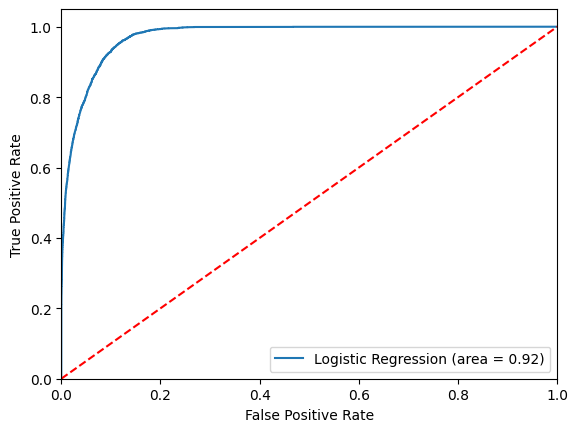

In [52]:
# This suggests overfitting
print('train accuracy:',rf_randomized_search.best_score_, rf_randomized_search.best_params_, '\n')

y_pred = rf_randomized_search.predict(X_test)
y_pred_proba = rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 6. Bagging

### 6.a Simple Bagging ExtraTrees

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.883742
Precision: 0.559084
Recall: 0.954680
F1 score: 0.705191
AUC: 0.913164


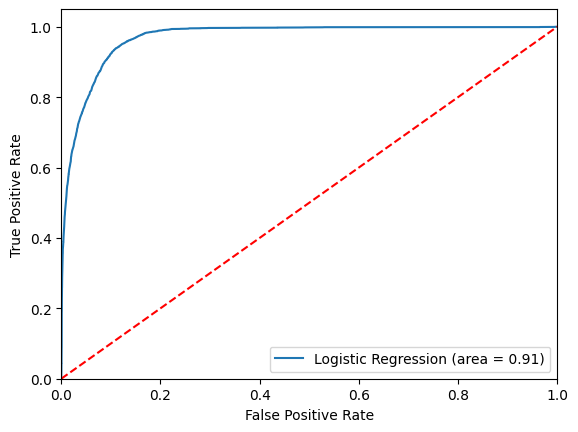

In [53]:
dt_bagging = BaggingClassifier(ExtraTreesClassifier())

dt_bagging.fit(X_train,y_train)

y_pred = dt_bagging.predict(X_test)
y_pred_proba = dt_bagging.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging ExtraTrees Hyperparameter Opt

In [54]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [55]:
n_iter = 50
cv = 3

bagging_tree = BaggingClassifier(DecisionTreeClassifier())

bagging_dt_randomized_search = RandomizedSearchCV(estimator=bagging_tree, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy',verbose=100)

bagging_dt_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 1/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.642 total time=  23.3s
[CV 2/3; 1/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 1/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.642 total time=  23.1s
[CV 3/3; 1/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 1/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=22, estimator__min_samples_split=37, max_features=0.99, max_samples=0.5, n_estimators=100;, score=0.638 total time=  23.1s
[CV 1/3; 2/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 2/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100;, score=0.592 total time=  10.9s
[CV 2/3; 2/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 2/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100;, score=0.593 total time=  10.8s
[CV 3/3; 2/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 2/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=22, estimator__min_samples_split=30, max_features=0.5, max_samples=0.1, n_estimators=100;, score=0.599 total time=  10.8s
[CV 1/3; 3/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 3/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.720 total time=   7.9s
[CV 2/3; 3/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 3/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.718 total time=   7.9s
[CV 3/3; 3/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 3/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=2, estimator__min_samples_split=4, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.720 total time=   7.8s
[CV 1/3; 4/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 4/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.640 total time=   1.1s
[CV 2/3; 4/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 4/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.647 total time=   1.1s
[CV 3/3; 4/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 4/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=10, estimator__min_samples_split=30, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.635 total time=   1.1s
[CV 1/3; 5/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 5/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20;, score=0.519 total time=   2.9s
[CV 2/3; 5/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 5/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20;, score=0.510 total time=   3.0s
[CV 3/3; 5/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 5/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=26, estimator__min_samples_split=6, max_features=0.75, max_samples=0.05, n_estimators=20;, score=0.509 total time=   3.0s
[CV 1/3; 6/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 6/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10;, score=0.717 total time=   1.8s
[CV 2/3; 6/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 6/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10;, score=0.716 total time=   1.8s
[CV 3/3; 6/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 6/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=12, estimator__min_samples_split=28, max_features=0.5, max_samples=0.5, n_estimators=10;, score=0.703 total time=   1.7s
[CV 1/3; 7/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40
[CV 1/3; 7/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 7/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 7/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3; 7/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40
[CV 3/3; 7/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=15, estimator__min_samples_leaf=6, estimator__min_samples_split=39, max_features=0.5, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3; 8/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 8/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 8/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10
[CV 2/3; 8/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 8/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 8/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=21, estimator__min_samples_split=37, max_features=0.75, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 9/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 9/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.586 total time=   0.5s
[CV 2/3; 9/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 9/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.579 total time=   0.5s
[CV 3/3; 9/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 9/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=29, estimator__min_samples_split=28, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.572 total time=   0.6s
[CV 1/3; 10/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 10/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.522 total time=   2.1s
[CV 2/3; 10/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 10/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.507 total time=   2.1s
[CV 3/3; 10/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 10/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=21, estimator__min_samples_split=6, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.519 total time=   2.1s
[CV 1/3; 11/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 11/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.645 total time=   5.0s
[CV 2/3; 11/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 11/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.615 total time=   5.0s
[CV 3/3; 11/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 11/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=37, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.626 total time=   5.0s
[CV 1/3; 12/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40
[CV 1/3; 12/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 12/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 12/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3; 12/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40
[CV 3/3; 12/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=18, estimator__min_samples_split=30, max_features=0.99, max_samples=0.05, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100
[CV 2/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=16, estimator__min_samples_leaf=36, estimator__min_samples_split=7, max_features=0.5, max_samples=0.1, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 14/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 14/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.544 total time=   5.1s
[CV 2/3; 14/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 14/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.551 total time=   5.1s
[CV 3/3; 14/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 14/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=10, estimator__min_samples_leaf=7, estimator__min_samples_split=37, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.549 total time=   5.1s
[CV 1/3; 15/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40
[CV 1/3; 15/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 15/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 15/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3; 15/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40
[CV 3/3; 15/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=2, estimator__min_samples_split=32, max_features=0.1, max_samples=0.5, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3; 16/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 16/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.572 total time=   0.6s
[CV 2/3; 16/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 16/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.595 total time=   0.6s
[CV 3/3; 16/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 16/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=21, estimator__min_samples_split=28, max_features=0.5, max_samples=0.1, n_estimators=5;, score=0.577 total time=   0.6s
[CV 1/3; 17/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 17/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100;, score=0.632 total time=   2.4s
[CV 2/3; 17/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 17/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100;, score=0.631 total time=   2.4s
[CV 3/3; 17/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 17/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=45, estimator__min_samples_leaf=3, estimator__min_samples_split=13, max_features=0.1, max_samples=0.05, n_estimators=100;, score=0.642 total time=   2.4s
[CV 1/3; 18/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10
[CV 1/3; 18/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 18/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 18/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 18/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10
[CV 3/3; 18/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=21, max_features=0.1, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 19/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 19/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=nan total time=   0.0s
[CV 2/3; 19/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5
[CV 2/3; 19/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=nan total time=   0.0s
[CV 3/3; 19/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 19/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=12, estimator__min_samples_leaf=21, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=nan total time=   0.0s
[CV 1/3; 20/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 20/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.582 total time=   1.1s
[CV 2/3; 20/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 20/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.593 total time=   1.1s
[CV 3/3; 20/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 20/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=13, estimator__min_samples_split=19, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.587 total time=   1.2s
[CV 1/3; 21/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20
[CV 1/3; 21/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 2/3; 21/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 21/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 3/3; 21/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20
[CV 3/3; 21/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=24, estimator__min_samples_split=23, max_features=0.75, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 1/3; 22/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 22/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.545 total time=   0.8s
[CV 2/3; 22/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 22/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.561 total time=   0.8s
[CV 3/3; 22/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 22/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=34, estimator__min_samples_leaf=4, estimator__min_samples_split=23, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.559 total time=   0.8s
[CV 1/3; 23/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 23/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5;, score=0.578 total time=   0.8s
[CV 2/3; 23/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 23/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5;, score=0.572 total time=   0.8s
[CV 3/3; 23/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 23/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=4, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=5;, score=0.576 total time=   0.8s
[CV 1/3; 24/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 24/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.594 total time=   0.6s
[CV 2/3; 24/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 24/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.569 total time=   0.6s
[CV 3/3; 24/50] START estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 24/50] END estimator__max_depth=30, estimator__max_features=auto, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=16, estimator__min_samples_split=39, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.567 total time=   0.6s
[CV 1/3; 25/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=5, estimator__min_samples_split=20, max_features=0.1, max_samples=0.5, n_estimators=100
[CV 1/3; 25/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=5, estimator__min_samples_split=20, max_features=0.1, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 25/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=5, estimator__min_samples_split=20, max_features=0.1, max_samples=0.5, n_estimators=100
[CV 2/3; 25/50] END estimator__max_depth=30, e

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[CV 3/3; 25/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=5, estimator__min_samples_split=20, max_features=0.1, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 26/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20
[CV 1/3; 26/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.571 total time=   0.5s
[CV 2/3; 26/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 26/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.587 total time=   0.5s
[CV 3/3; 26/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 26/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=23, estimator__min_samples_split=5, max_features=0.1, max_samples=0.2, n_estimators=20;, score=0.585 total time=   0.4s
[CV 1/3; 27/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10
[CV 1/3; 27/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 27/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 27/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 27/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10
[CV 3/3; 27/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=34, estimator__min_samples_split=38, max_features=0.5, max_samples=0.05, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 28/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 28/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.566 total time=  15.1s
[CV 2/3; 28/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 28/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.556 total time=  15.0s
[CV 3/3; 28/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 28/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=36, estimator__min_samples_split=32, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.562 total time=  15.1s
[CV 1/3; 29/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 29/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.506 total time=   0.8s
[CV 2/3; 29/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 29/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.525 total time=   0.8s
[CV 3/3; 29/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 29/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=31, estimator__min_samples_split=28, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.540 total time=   0.8s
[CV 1/3; 30/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10
[CV 1/3; 30/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 30/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 30/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 30/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10
[CV 3/3; 30/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=8, estimator__min_samples_split=16, max_features=0.75, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 31/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 31/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.604 total time=   6.4s
[CV 2/3; 31/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 31/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.602 total time=   6.5s
[CV 3/3; 31/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 31/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=37, estimator__min_samples_split=26, max_features=0.75, max_samples=0.05, n_estimators=40;, score=0.612 total time=   6.4s
[CV 1/3; 32/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20
[CV 1/3; 32/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 2/3; 32/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 32/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 3/3; 32/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20
[CV 3/3; 32/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=57, estimator__min_samples_leaf=2, estimator__min_samples_split=26, max_features=0.5, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 1/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.538 total time=   4.1s
[CV 2/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.537 total time=   4.0s
[CV 3/3; 33/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 33/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=22, estimator__min_samples_split=34, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.541 total time=   4.0s
[CV 1/3; 34/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 34/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.713 total time=   4.7s
[CV 2/3; 34/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 34/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.709 total time=   4.6s
[CV 3/3; 34/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 34/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=36, estimator__min_samples_split=38, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.718 total time=   4.6s
[CV 1/3; 35/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 35/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10;, score=0.610 total time=   1.8s
[CV 2/3; 35/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 35/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10;, score=0.622 total time=   1.8s
[CV 3/3; 35/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 35/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=8, estimator__min_samples_split=18, max_features=0.75, max_samples=0.1, n_estimators=10;, score=0.612 total time=   1.8s
[CV 1/3; 36/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5
[CV 1/3; 36/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5;, score=nan total time=   0.0s
[CV 2/3; 36/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 36/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5;, score=nan total time=   0.0s
[CV 3/3; 36/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5
[CV 3/3; 36/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=13, estimator__min_samples_split=11, max_features=0.5, max_samples=0.1, n_estimators=5;, score=nan total time=   0.0s
[CV 1/3; 37/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 37/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40;, score=0.579 total time=   8.1s
[CV 2/3; 37/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 37/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40;, score=0.576 total time=   8.1s
[CV 3/3; 37/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 37/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=52, estimator__min_samples_leaf=15, estimator__min_samples_split=21, max_features=0.99, max_samples=0.05, n_estimators=40;, score=0.569 total time=   8.1s
[CV 1/3; 38/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 1/3; 38/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 2/3; 38/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 38/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 3/3; 38/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40
[CV 3/3; 38/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=11, estimator__min_samples_split=25, max_features=0.99, max_samples=0.1, n_estimators=40;, score=nan total time=   0.0s
[CV 1/3; 39/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 39/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100;, score=0.562 total time=  10.2s
[CV 2/3; 39/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 39/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100;, score=0.560 total time=  10.1s
[CV 3/3; 39/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 39/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=36, estimator__min_samples_split=36, max_features=0.5, max_samples=0.05, n_estimators=100;, score=0.570 total time=  10.1s
[CV 1/3; 40/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 40/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.679 total time=   1.8s
[CV 2/3; 40/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 40/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.679 total time=   1.8s
[CV 3/3; 40/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 40/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=5, estimator__min_samples_split=24, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.669 total time=   1.8s
[CV 1/3; 41/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 41/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.548 total time=   0.8s
[CV 2/3; 41/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 41/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.587 total time=   0.8s
[CV 3/3; 41/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 41/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=22, estimator__min_samples_leaf=4, estimator__min_samples_split=27, max_features=0.75, max_samples=0.2, n_estimators=5;, score=0.571 total time=   0.8s
[CV 1/3; 42/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 42/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.530 total time=  14.9s
[CV 2/3; 42/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 42/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.545 total time=  15.1s
[CV 3/3; 42/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 42/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.516 total time=  14.9s
[CV 1/3; 43/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20
[CV 1/3; 43/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 2/3; 43/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 43/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 3/3; 43/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20
[CV 3/3; 43/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=35, estimator__min_samples_split=30, max_features=0.25, max_samples=0.2, n_estimators=20;, score=nan total time=   0.0s
[CV 1/3; 44/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 44/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20;, score=0.523 total time=   0.5s
[CV 2/3; 44/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 44/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20;, score=0.545 total time=   0.4s
[CV 3/3; 44/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 44/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=17, estimator__min_samples_split=26, max_features=0.1, max_samples=0.05, n_estimators=20;, score=0.528 total time=   0.4s
[CV 1/3; 45/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 45/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.564 total time=   0.6s
[CV 2/3; 45/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 45/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.576 total time=   0.6s
[CV 3/3; 45/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 45/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=6, estimator__min_samples_split=23, max_features=0.25, max_samples=0.05, n_estimators=10;, score=0.582 total time=   0.6s
[CV 1/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.725 total time=  11.1s
[CV 2/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.735 total time=  11.1s
[CV 3/3; 46/50] START estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 46/50] END estimator__max_depth=100, estimator__max_features=auto, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=34, estimator__min_samples_split=14, max_features=0.99, max_samples=0.5, n_estimators=40;, score=0.740 total time=  11.1s
[CV 1/3; 47/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10
[CV 1/3; 47/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 47/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 47/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 47/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10
[CV 3/3; 47/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=14, estimator__min_samples_leaf=35, estimator__min_samples_split=18, max_features=0.25, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 48/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 48/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.543 total time=   5.2s
[CV 2/3; 48/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 48/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.551 total time=   5.2s
[CV 3/3; 48/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 48/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=40, estimator__min_samples_leaf=32, estimator__min_samples_split=27, max_features=0.25, max_samples=0.05, n_estimators=100;, score=0.527 total time=   5.1s
[CV 1/3; 49/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 49/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.600 total time=   1.0s
[CV 2/3; 49/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 49/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.593 total time=   1.1s
[CV 3/3; 49/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 49/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=16, estimator__min_samples_split=22, max_features=0.99, max_samples=0.5, n_estimators=5;, score=0.573 total time=   1.1s
[CV 1/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100;, score=0.547 total time=   2.2s
[CV 2/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100;, score=0.550 total time=   2.2s
[CV 3/3; 50/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 50/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=24, estimator__min_samples_split=16, max_features=0.1, max_samples=0.1, n_estimators=100;, score=0.530 total time=   2.1s


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
48 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 339, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 474, in _fit
    all_results = Parallel(


RandomizedSearchCV(cv=3,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                   n_iter=50,
                   param_distributions={'estimator__max_depth': [1, 2, 3, 10,
                                                                 30, 100],
                                        'estimator__max_features': ['None',
                                                                    'auto',
                                                                    'sqrt',
                                                                    'log2'],
                                        'estimator__max_leaf_nodes': [10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                      26, 27,
                                                                      28, 29,
                                                                      30, 31,
                                                                      32, 33,
                                                                      34, 35,
                                                                      36, 37,
                                                                      38, 39, ...],
                                        'estimator...leaf': [2, 3, 4,
                                                                        5, 6, 7,
                                                                        8, 9,
                                                                        10, 11,
                                                                        12, 13,
                                                                        14, 15,
                                                                        16, 17,
                                                                        18, 19,
                                                                        20, 21,
                                                                        22, 23,
                                                                        24, 25,
                                                                        26, 27,
                                                                        28, 29,
                                                                        30, 31, ...],
                                        'estimator__min_samples_split': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18, 19,
                                                                         20, 21,
                                                                         22, 23,
                                                                         24, 25,
                                                                         26, 27,
                                                                   

train accuracy: 0.7333805763649862 {'n_estimators': 40, 'max_samples': 0.5, 'max_features': 0.99, 'estimator__min_samples_split': 14, 'estimator__min_samples_leaf': 34, 'estimator__max_leaf_nodes': 27, 'estimator__max_features': 'auto', 'estimator__max_depth': 100} 

Accuracy: 0.779860
Precision: 0.367450
Recall: 0.708929
F1 score: 0.484022
AUC: 0.750441


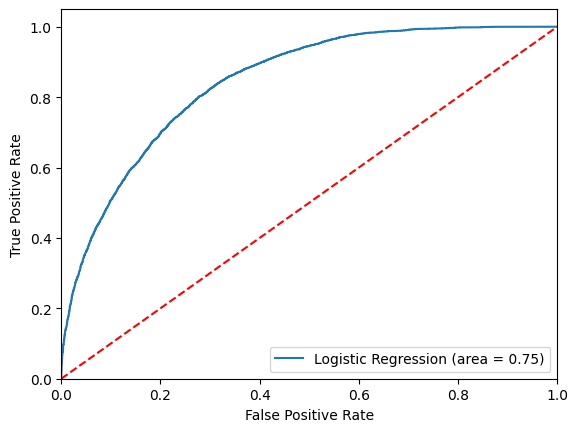

In [56]:
print('train accuracy:',bagging_dt_randomized_search.best_score_, bagging_dt_randomized_search.best_params_, '\n')

y_pred = bagging_dt_randomized_search.predict(X_test)
y_pred_proba = bagging_dt_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Simple Bagging RandomForest

In [57]:
bagging_rf = BaggingClassifier(RandomForestClassifier())

bagging_rf.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(estimator=RandomForestClassifier())

Accuracy: 0.878791
Precision: 0.548337
Recall: 0.951713
F1 score: 0.695789
AUC: 0.909037


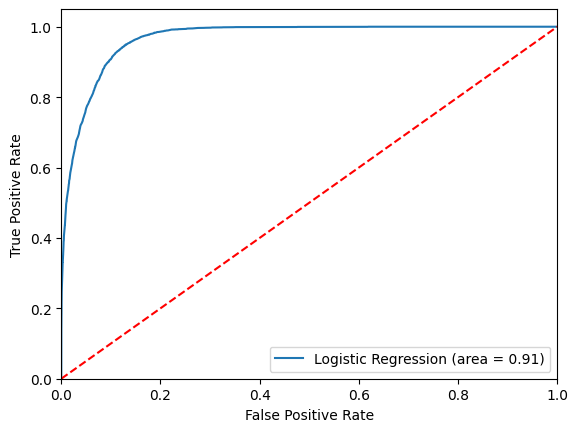

In [58]:
y_pred = bagging_rf.predict(X_test)
y_pred_proba = bagging_rf.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging RandomForest Hyperparameter Opt

In [59]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [60]:
n_iter = 50
cv = 3

bagging_random_forest = BaggingClassifier(RandomForestClassifier())

bagging_rf_randomized_search = RandomizedSearchCV(estimator=bagging_random_forest, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=100)

bagging_rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 1/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.593 total time=   9.5s
[CV 2/3; 1/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 1/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.593 total time=   9.5s
[CV 3/3; 1/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 1/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=21, estimator__min_samples_split=18, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.587 total time=   9.4s
[CV 1/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.557 total time= 1.9min
[CV 2/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.557 total time= 1.9min
[CV 3/3; 2/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 2/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=36, estimator__min_samples_split=11, max_features=0.75, max_samples=0.5, n_estimators=100;, score=0.543 total time= 1.9min
[CV 1/3; 3/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 3/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.684 total time= 1.3min
[CV 2/3; 3/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 3/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.680 total time= 1.3min
[CV 3/3; 3/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 3/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=19, estimator__min_samples_split=37, max_features=0.5, max_samples=0.5, n_estimators=40;, score=0.686 total time= 1.3min
[CV 1/3; 4/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 4/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.577 total time=  16.7s
[CV 2/3; 4/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 4/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.591 total time=  16.4s
[CV 3/3; 4/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 4/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=37, estimator__min_samples_split=16, max_features=0.1, max_samples=0.05, n_estimators=40;, score=0.574 total time=  16.0s
[CV 1/3; 5/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.534 total time=  14.7s
[CV 2/3; 5/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.497 total time=  14.8s
[CV 3/3; 5/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 5/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=36, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.568 total time=  14.6s
[CV 1/3; 6/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10
[CV 1/3; 6/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 6/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 6/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 6/50] START estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10
[CV 3/3; 6/50] END estimator__max_depth=2, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=33, estimator__min_samples_split=31, max_features=0.25, max_samples=0.5, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 7/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='a

[CV 1/3; 7/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.693 total time= 1.0min
[CV 2/3; 7/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 7/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.683 total time=  57.3s
[CV 3/3; 7/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 7/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=34, estimator__min_samples_split=24, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.695 total time=  59.2s
[CV 1/3; 8/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 8/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.581 total time= 1.1min
[CV 2/3; 8/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 8/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.581 total time= 1.1min
[CV 3/3; 8/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 8/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=7, estimator__min_samples_split=15, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.573 total time= 1.1min
[CV 1/3; 9/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 9/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.619 total time=   7.4s
[CV 2/3; 9/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 9/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.608 total time=   7.4s
[CV 3/3; 9/50] START estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 9/50] END estimator__max_depth=10, estimator__max_features=sqrt, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=9, estimator__min_samples_split=27, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.623 total time=   7.6s
[CV 1/3; 10/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 10/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.556 total time=  14.6s
[CV 2/3; 10/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 10/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.552 total time=  14.6s
[CV 3/3; 10/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 10/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=53, estimator__min_samples_leaf=8, estimator__min_samples_split=19, max_features=0.25, max_samples=0.5, n_estimators=20;, score=0.546 total time=  14.3s
[CV 1/3; 11/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 11/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.728 total time= 8.8min
[CV 2/3; 11/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 11/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.716 total time= 8.5min
[CV 3/3; 11/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 11/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=9, estimator__min_samples_split=17, max_features=0.5, max_samples=0.5, n_estimators=100;, score=0.728 total time= 8.5min
[CV 1/3; 12/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 12/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.623 total time=  44.4s
[CV 2/3; 12/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 12/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.621 total time=  44.1s
[CV 3/3; 12/50] START estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 12/50] END estimator__max_depth=3, estimator__max_features=sqrt, estimator__max_leaf_nodes=30, estimator__min_samples_leaf=22, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=20;, score=0.625 total time=  44.7s
[CV 1/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20
[CV 1/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 2/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 3/3; 13/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20
[CV 3/3; 13/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=5, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=nan total time=   0.0s
[CV 1/3; 14/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 14/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.670 total time= 3.4min
[CV 2/3; 14/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 14/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.670 total time= 3.4min
[CV 3/3; 14/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 14/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=32, estimator__min_samples_leaf=38, estimator__min_samples_split=11, max_features=0.25, max_samples=0.2, n_estimators=100;, score=0.669 total time= 3.3min
[CV 1/3; 15/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 15/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.579 total time=   9.0s
[CV 2/3; 15/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 15/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.564 total time=   8.9s
[CV 3/3; 15/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 15/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=31, estimator__min_samples_leaf=19, estimator__min_samples_split=24, max_features=0.25, max_samples=0.05, n_estimators=20;, score=0.568 total time=   9.1s
[CV 1/3; 16/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 16/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.556 total time=   2.3s
[CV 2/3; 16/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 16/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.515 total time=   2.3s
[CV 3/3; 16/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 16/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=24, estimator__min_samples_leaf=16, estimator__min_samples_split=25, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.535 total time=   2.3s
[CV 1/3; 17/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 17/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.610 total time=  59.7s
[CV 2/3; 17/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 17/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.602 total time= 1.0min
[CV 3/3; 17/50] START estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 17/50] END estimator__max_depth=30, estimator__max_features=log2, estimator__max_leaf_nodes=47, estimator__min_samples_leaf=36, estimator__min_samples_split=22, max_features=0.75, max_samples=0.05, n_estimators=100;, score=0.597 total time= 1.0min
[CV 1/3; 18/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100
[CV 1/3; 18/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 18/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 18/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 18/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100
[CV 3/3; 18/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=42, estimator__min_samples_leaf=28, estimator__min_samples_split=13, max_features=0.5, max_samples=0.5, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 19/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='a

[CV 1/3; 19/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.570 total time=  13.4s
[CV 2/3; 19/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 19/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.556 total time=  13.6s
[CV 3/3; 19/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 19/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=18, estimator__min_samples_split=25, max_features=0.5, max_samples=0.2, n_estimators=20;, score=0.532 total time=  13.3s
[CV 1/3; 20/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 20/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.628 total time=   9.4s
[CV 2/3; 20/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 20/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.620 total time=   9.8s
[CV 3/3; 20/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 20/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=21, estimator__min_samples_leaf=32, estimator__min_samples_split=36, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.617 total time=   9.3s
[CV 1/3; 21/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 21/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.535 total time=  11.5s
[CV 2/3; 21/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 21/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.558 total time=  11.6s
[CV 3/3; 21/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 21/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=41, estimator__min_samples_leaf=26, estimator__min_samples_split=29, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.543 total time=  11.5s
[CV 1/3; 22/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 22/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.555 total time=  25.9s
[CV 2/3; 22/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 22/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.559 total time=  26.4s
[CV 3/3; 22/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 22/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=14, estimator__min_samples_split=33, max_features=0.99, max_samples=0.5, n_estimators=20;, score=0.544 total time=  25.8s
[CV 1/3; 23/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 23/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.583 total time=  12.8s
[CV 2/3; 23/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 23/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.589 total time=  12.8s
[CV 3/3; 23/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 23/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=11, estimator__min_samples_leaf=31, estimator__min_samples_split=39, max_features=0.99, max_samples=0.05, n_estimators=20;, score=0.587 total time=  12.9s
[CV 1/3; 24/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 24/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.557 total time=  11.4s
[CV 2/3; 24/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 24/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.557 total time=  11.3s
[CV 3/3; 24/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 24/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=27, estimator__min_samples_leaf=13, estimator__min_samples_split=31, max_features=0.75, max_samples=0.5, n_estimators=10;, score=0.531 total time=  11.6s
[CV 1/3; 25/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 25/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.531 total time=  17.2s
[CV 2/3; 25/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 25/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.564 total time=  17.0s
[CV 3/3; 25/50] START estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 25/50] END estimator__max_depth=1, estimator__max_features=log2, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=25, estimator__min_samples_split=38, max_features=0.5, max_samples=0.2, n_estimators=40;, score=0.536 total time=  16.9s
[CV 1/3; 26/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 26/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.612 total time=  20.5s
[CV 2/3; 26/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 26/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.611 total time=  20.6s
[CV 3/3; 26/50] START estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 26/50] END estimator__max_depth=3, estimator__max_features=auto, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=9, estimator__min_samples_split=21, max_features=0.1, max_samples=0.5, n_estimators=20;, score=0.614 total time=  20.6s
[CV 1/3; 27/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 27/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.593 total time=   5.3s
[CV 2/3; 27/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 27/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.591 total time=   5.3s
[CV 3/3; 27/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 27/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=30, estimator__min_samples_split=13, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.603 total time=   5.2s
[CV 1/3; 28/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 28/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.626 total time=  42.2s
[CV 2/3; 28/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 28/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.635 total time=  42.0s
[CV 3/3; 28/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 28/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=26, estimator__min_samples_leaf=15, estimator__min_samples_split=26, max_features=0.5, max_samples=0.05, n_estimators=40;, score=0.625 total time=  41.9s
[CV 1/3; 29/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 29/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.672 total time=  18.7s
[CV 2/3; 29/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 29/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.670 total time=  18.9s
[CV 3/3; 29/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 29/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=55, estimator__min_samples_leaf=18, estimator__min_samples_split=19, max_features=0.5, max_samples=0.1, n_estimators=10;, score=0.659 total time=  18.7s
[CV 1/3; 30/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 30/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.638 total time=  22.3s
[CV 2/3; 30/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 30/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.642 total time=  23.7s
[CV 3/3; 30/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 30/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=35, estimator__min_samples_split=11, max_features=0.25, max_samples=0.1, n_estimators=20;, score=0.633 total time=  22.8s
[CV 1/3; 31/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 31/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.560 total time=   6.8s
[CV 2/3; 31/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 31/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.551 total time=   6.6s
[CV 3/3; 31/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 31/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=30, estimator__min_samples_split=11, max_features=0.75, max_samples=0.05, n_estimators=10;, score=0.571 total time=   6.7s
[CV 1/3; 32/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 32/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.545 total time=  50.2s
[CV 2/3; 32/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 32/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.560 total time=  49.9s
[CV 3/3; 32/50] START estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 32/50] END estimator__max_depth=1, estimator__max_features=sqrt, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=19, estimator__min_samples_split=18, max_features=0.1, max_samples=0.5, n_estimators=100;, score=0.544 total time=  49.4s
[CV 1/3; 33/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 33/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.507 total time=   4.1s
[CV 2/3; 33/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 33/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.544 total time=   3.9s
[CV 3/3; 33/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 33/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=25, estimator__min_samples_leaf=27, estimator__min_samples_split=27, max_features=0.5, max_samples=0.05, n_estimators=10;, score=0.527 total time=   3.9s
[CV 1/3; 34/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 34/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.576 total time=   1.9s
[CV 2/3; 34/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 34/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.572 total time=   1.9s
[CV 3/3; 34/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 34/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=3, estimator__min_samples_split=33, max_features=0.25, max_samples=0.05, n_estimators=5;, score=0.564 total time=   1.9s
[CV 1/3; 35/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 35/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.628 total time=  29.9s
[CV 2/3; 35/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 35/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.622 total time=  30.2s
[CV 3/3; 35/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 35/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=18, estimator__min_samples_split=38, max_features=0.25, max_samples=0.05, n_estimators=40;, score=0.620 total time=  30.0s
[CV 1/3; 36/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 36/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.590 total time=   4.2s
[CV 2/3; 36/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 36/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.605 total time=   4.2s
[CV 3/3; 36/50] START estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 36/50] END estimator__max_depth=3, estimator__max_features=log2, estimator__max_leaf_nodes=39, estimator__min_samples_leaf=24, estimator__min_samples_split=21, max_features=0.25, max_samples=0.5, n_estimators=5;, score=0.606 total time=   4.1s
[CV 1/3; 37/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 37/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.722 total time=  32.4s
[CV 2/3; 37/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 37/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.728 total time=  31.4s
[CV 3/3; 37/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 37/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=33, estimator__min_samples_leaf=11, estimator__min_samples_split=17, max_features=0.75, max_samples=0.5, n_estimators=5;, score=0.718 total time=  31.4s
[CV 1/3; 38/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 38/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.564 total time=   5.0s
[CV 2/3; 38/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 38/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.566 total time=   5.0s
[CV 3/3; 38/50] START estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 38/50] END estimator__max_depth=2, estimator__max_features=sqrt, estimator__max_leaf_nodes=17, estimator__min_samples_leaf=17, estimator__min_samples_split=33, max_features=0.5, max_samples=0.2, n_estimators=5;, score=0.551 total time=   5.0s
[CV 1/3; 39/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 39/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.629 total time=   9.0s
[CV 2/3; 39/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 39/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.626 total time=   9.0s
[CV 3/3; 39/50] START estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 39/50] END estimator__max_depth=100, estimator__max_features=log2, estimator__max_leaf_nodes=59, estimator__min_samples_leaf=36, estimator__min_samples_split=24, max_features=0.99, max_samples=0.1, n_estimators=10;, score=0.630 total time=   8.9s
[CV 1/3; 40/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 40/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10;, score=0.725 total time= 1.2min
[CV 2/3; 40/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 40/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10;, score=0.718 total time= 1.1min
[CV 3/3; 40/50] START estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 40/50] END estimator__max_depth=30, estimator__max_features=sqrt, estimator__max_leaf_nodes=29, estimator__min_samples_leaf=22, estimator__min_samples_split=26, max_features=0.99, max_samples=0.5, n_estimators=10;, score=0.730 total time= 1.1min
[CV 1/3; 41/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100
[CV 1/3; 41/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 41/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 41/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 41/50] START estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100
[CV 3/3; 41/50] END estimator__max_depth=3, estimator__max_features=None, estimator__max_leaf_nodes=48, estimator__min_samples_leaf=12, estimator__min_samples_split=25, max_features=0.5, max_samples=0.05, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 42/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 42/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 2/3; 42/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10
[CV 2/3; 42/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 3/3; 42/50] START estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 42/50] END estimator__max_depth=30, estimator__max_features=None, estimator__max_leaf_nodes=38, estimator__min_samples_leaf=2, estimator__min_samples_split=23, max_features=0.5, max_samples=0.1, n_estimators=10;, score=nan total time=   0.0s
[CV 1/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.504 total time=   2.3s
[CV 2/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.566 total time=   2.3s
[CV 3/3; 43/50] START estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 43/50] END estimator__max_depth=2, estimator__max_features=log2, estimator__max_leaf_nodes=43, estimator__min_samples_leaf=37, estimator__min_samples_split=21, max_features=0.75, max_samples=0.05, n_estimators=5;, score=0.526 total time=   2.3s
[CV 1/3; 44/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 44/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5;, score=0.716 total time=  13.1s
[CV 2/3; 44/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 44/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5;, score=0.707 total time=  12.7s
[CV 3/3; 44/50] START estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 44/50] END estimator__max_depth=100, estimator__max_features=sqrt, estimator__max_leaf_nodes=51, estimator__min_samples_leaf=25, estimator__min_samples_split=10, max_features=0.1, max_samples=0.5, n_estimators=5;, score=0.713 total time=  12.8s
[CV 1/3; 45/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100
[CV 1/3; 45/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3; 45/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 45/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3; 45/50] START estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100
[CV 3/3; 45/50] END estimator__max_depth=100, estimator__max_features=None, estimator__max_leaf_nodes=49, estimator__min_samples_leaf=7, estimator__min_samples_split=14, max_features=0.1, max_samples=0.2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 46/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='a

[CV 1/3; 46/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40;, score=0.536 total time=  20.4s
[CV 2/3; 46/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 46/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40;, score=0.558 total time=  20.5s
[CV 3/3; 46/50] START estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 46/50] END estimator__max_depth=1, estimator__max_features=auto, estimator__max_leaf_nodes=56, estimator__min_samples_leaf=35, estimator__min_samples_split=24, max_features=0.25, max_samples=0.2, n_estimators=40;, score=0.545 total time=  20.8s
[CV 1/3; 47/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 47/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.625 total time= 1.5min
[CV 2/3; 47/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 47/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.626 total time= 1.5min
[CV 3/3; 47/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 47/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=19, estimator__min_samples_leaf=35, estimator__min_samples_split=38, max_features=0.75, max_samples=0.1, n_estimators=100;, score=0.627 total time= 1.5min
[CV 1/3; 48/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100
[CV 1/3; 48/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100;, score=nan total time=   0.1s
[CV 2/3; 48/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 48/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100;, score=nan total time=   0.1s
[CV 3/3; 48/50] START estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100
[CV 3/3; 48/50] END estimator__max_depth=10, estimator__max_features=None, estimator__max_leaf_nodes=35, estimator__min_samples_leaf=27, estimator__min_samples_split=28, max_features=0.99, max_samples=0.05, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3; 49/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/3; 49/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5;, score=0.635 total time=   5.2s
[CV 2/3; 49/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/3; 49/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5;, score=0.632 total time=   5.1s
[CV 3/3; 49/50] START estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/3; 49/50] END estimator__max_depth=10, estimator__max_features=log2, estimator__max_leaf_nodes=28, estimator__min_samples_leaf=35, estimator__min_samples_split=29, max_features=0.1, max_samples=0.2, n_estimators=5;, score=0.636 total time=   4.8s
[CV 1/3; 50/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 1/3; 50/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.740 total time= 7.0min
[CV 2/3; 50/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 2/3; 50/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.732 total time= 6.9min
[CV 3/3; 50/50] START estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Felipe\minico

[CV 3/3; 50/50] END estimator__max_depth=10, estimator__max_features=auto, estimator__max_leaf_nodes=50, estimator__min_samples_leaf=22, estimator__min_samples_split=39, max_features=0.25, max_samples=0.5, n_estimators=100;, score=0.739 total time= 6.9min


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 339, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 474, in _fit
    all_results = Parallel(


RandomizedSearchCV(cv=3,
                   estimator=BaggingClassifier(estimator=RandomForestClassifier()),
                   n_iter=50,
                   param_distributions={'estimator__max_depth': [1, 2, 3, 10,
                                                                 30, 100],
                                        'estimator__max_features': ['None',
                                                                    'auto',
                                                                    'sqrt',
                                                                    'log2'],
                                        'estimator__max_leaf_nodes': [10, 11,
                                                                      12, 13,
                                                                      14, 15,
                                                                      16, 17,
                                                                      18, 19,
                                                                      20, 21,
                                                                      22, 23,
                                                                      24, 25,
                                                                      26, 27,
                                                                      28, 29,
                                                                      30, 31,
                                                                      32, 33,
                                                                      34, 35,
                                                                      36, 37,
                                                                      38, 39, ...],
                                        'estimator...leaf': [2, 3, 4,
                                                                        5, 6, 7,
                                                                        8, 9,
                                                                        10, 11,
                                                                        12, 13,
                                                                        14, 15,
                                                                        16, 17,
                                                                        18, 19,
                                                                        20, 21,
                                                                        22, 23,
                                                                        24, 25,
                                                                        26, 27,
                                                                        28, 29,
                                                                        30, 31, ...],
                                        'estimator__min_samples_split': [2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10, 11,
                                                                         12, 13,
                                                                         14, 15,
                                                                         16, 17,
                                                                         18, 19,
                                                                         20, 21,
                                                                         22, 23,
                                                                         24, 25,
                                                                         26, 27,
                                                                   

train accuracy: 0.737227508942431 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.25, 'estimator__min_samples_split': 39, 'estimator__min_samples_leaf': 22, 'estimator__max_leaf_nodes': 50, 'estimator__max_features': 'auto', 'estimator__max_depth': 10} 

Accuracy: 0.798837
Precision: 0.395318
Recall: 0.719719
F1 score: 0.510329
AUC: 0.766022


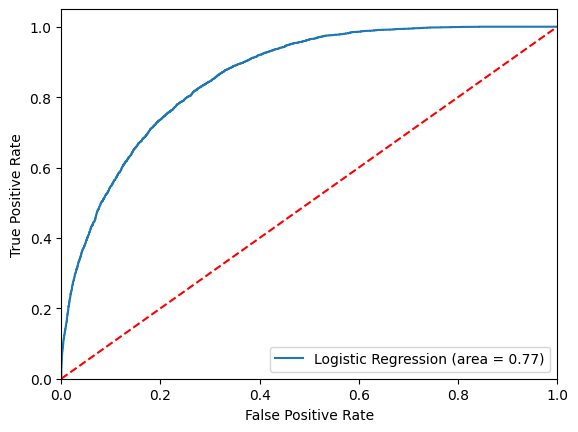

In [61]:
print('train accuracy:',bagging_rf_randomized_search.best_score_, bagging_rf_randomized_search.best_params_, '\n')

y_pred = bagging_rf_randomized_search.predict(X_test)
y_pred_proba = bagging_rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 7. ExtraTrees

### 7.a Simple ExtraTrees

In [62]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_14424\636858048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees.fit(X_train,y_train)


ExtraTreesClassifier()

Accuracy: 0.911205
Precision: 0.625542
Recall: 0.972484
F1 score: 0.761352
AUC: 0.936622


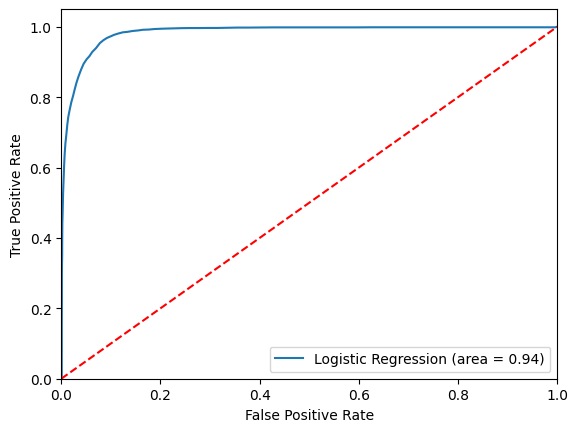

In [63]:
y_pred = extra_trees.predict(X_test)
y_pred_proba = extra_trees.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 7.b ExtraTrees hyperparameter opt

In [64]:
extra_trees_parameter = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 1200, 1500, 1800, 1900, 2000, 2100, 3000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None],
    'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    'min_samples_leaf': [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    # 'min_weight_fraction_leaf': [x / 10 for x in range(0, 6)],
    'max_features': ['auto', 'sqrt', 'log2', 2, 5, 8, 13, 21, 34, None],
    'max_leaf_nodes': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, None],
    'min_impurity_decrease': [x / 100 for x in range(0, 11)],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    #'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators': range(1800, 2100, 10),
    
}

In [66]:
n_iter = 100
cv = 3

extra_trees = ExtraTreesClassifier()

extra_trees_randomized_search = RandomizedSearchCV(estimator=extra_trees, 
                                         param_distributions=extra_trees_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

extra_trees_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

In [67]:
y_pred = extra_trees_randomized_search.predict(X_test)
y_pred_proba = extra_trees_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## 8. AdaBoost

### 8.a Simple AdaBoost

In [68]:
adaboost_cls = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=semilla), n_estimators=100)

adaboost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=2023),
                   n_estimators=100)

Accuracy: 0.908102
Precision: 0.617445
Recall: 0.970057
F1 score: 0.754590
AUC: 0.933798


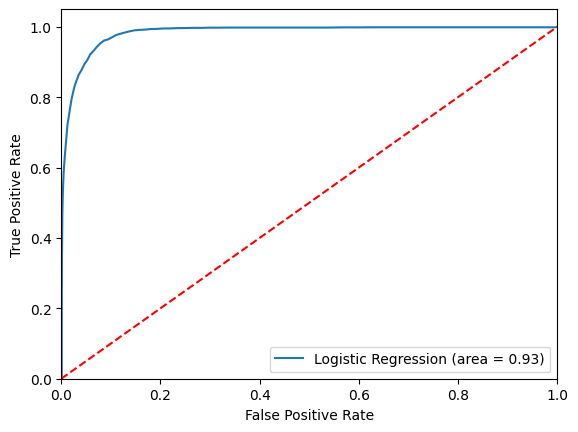

In [69]:
y_pred = adaboost_cls.predict(X_test)
y_pred_proba = adaboost_cls.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 9. GradientBoosting

### 9.a Simple GradientBoosting

In [70]:
grad_boost_cls = GradientBoostingClassifier()

grad_boost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

Accuracy: 0.717586
Precision: 0.312507
Recall: 0.782574
F1 score: 0.446651
AUC: 0.744540


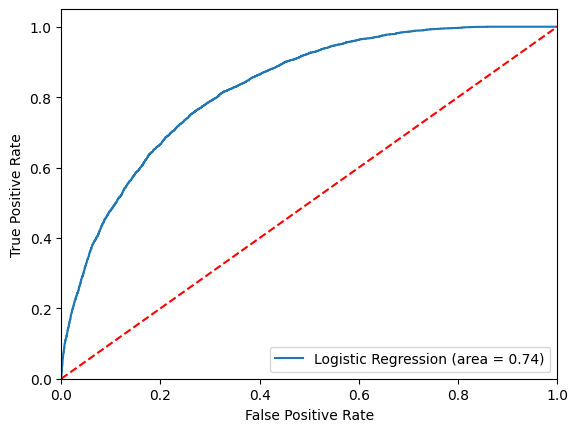

In [71]:
y_pred = grad_boost_cls.predict(X_test)
y_pred_proba = grad_boost_cls.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 9. XGBoost

### 9.a Simple XGBoost

In [72]:
xgb = XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=3,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Accuracy: 0.899419
Precision: 0.595887
Recall: 0.961424
F1 score: 0.735756
AUC: 0.925136


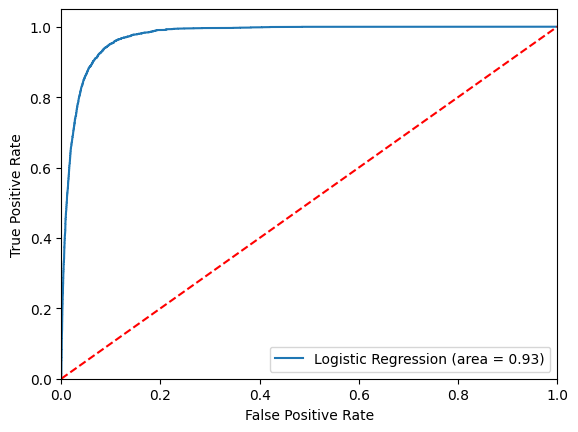

In [73]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 9.b XGBooost Hyperparameter opt

In [74]:
xgboost_parameter = {
    'max_depth':list(range(3,15))+[None],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': range(1, 10, 1),
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

In [75]:
n_iter = 100
cv = 3

xgb = XGBClassifier()

xgb_randomized_search = RandomizedSearchCV(estimator=xgb, 
                                         param_distributions=xgboost_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', verbose=2)

xgb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[11:20:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[CV] END base_score=0.2, booster=gblinear, colsample_bylevel=0.6, colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_depth=11, min_child_weight=6, n_estimators=300, reg_alpha=0, reg_lambda=5, subsample=0.8; total time=   8.7s
[11:20:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_bylevel", "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[CV] END base_score=0.2, booster=gblinear, colsample_bylevel=0.6, colsample_bytree=0.7, gamma=0, learning_rate=0.5, max_depth=11, min_child_weig

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
93 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py", line 1490, in fit
    self._Booster = train(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py"

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          0.5, 0.7],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, None],
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy', verbose=2)

Accuracy: 0.949709
Precision: 0.746897
Recall: 0.990289
F1 score: 0.851543
AUC: 0.966540


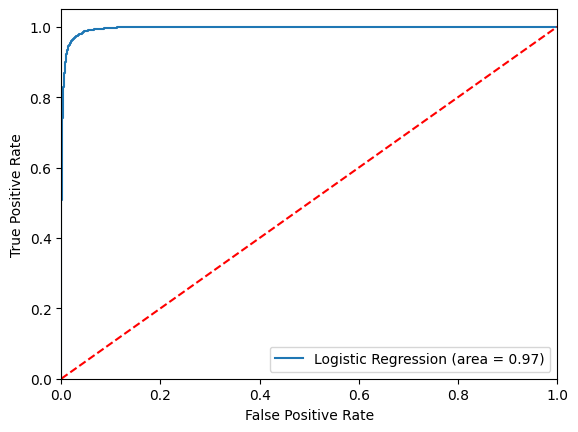

In [76]:
y_pred = xgb_randomized_search.predict(X_test)
y_pred_proba = xgb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

In [77]:
save_model(xgb_randomized_search, 'lsa_xgb_randomized_search.sav')

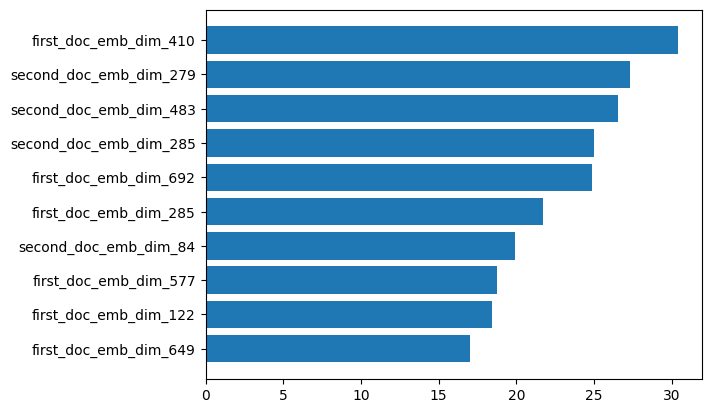

In [79]:
importance = xgb_randomized_search.best_estimator_.get_booster().get_score(importance_type='gain') # Importance: gain
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)) # Sort by descending importance

top_n = dict(list(sorted_importance.items())[:10]) # Keep top N

# Plot
plt.barh(range(len(top_n)), list(top_n.values())[::-1], align='center')
plt.yticks(range(len(top_n)), list(top_n.keys())[::-1])
plt.show()

## 10. LightGBM

### 10.a Simple LightGBM

In [80]:
lgbm = LGBMClassifier(n_jobs=3, verbose=-1)
lgbm.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_jobs=3, verbose=-1)

Accuracy: 0.850385
Precision: 0.492938
Recall: 0.950904
F1 score: 0.649291
AUC: 0.892076


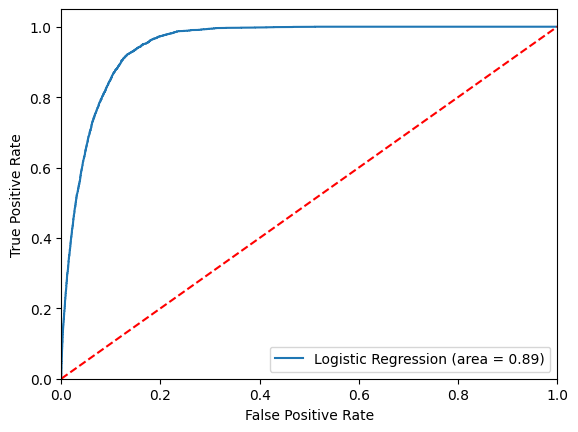

In [81]:
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 11. CatBoost

### 11.a Simple CatBoost

In [82]:
catb = CatBoostClassifier(thread_count=3, verbose=False)
catb.fit(X_train,y_train)

Accuracy: 0.901501
Precision: 0.600402
Recall: 0.967899
F1 score: 0.741093
AUC: 0.929040


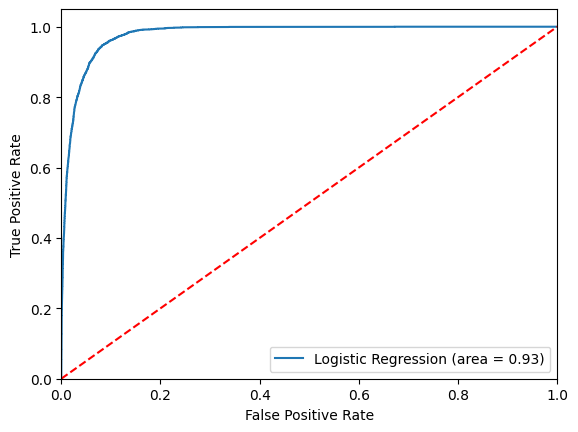

In [83]:
y_pred = catb.predict(X_test)
y_pred_proba = catb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 11.b CatBoost hyperparameter opt

In [84]:
catb_parameters = {
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'depth': range(3, 15, 1),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 96, 128, 160],
    'bagging_temperature': [0, 0.1, 0.5, 1, 2, 5],
    'random_strength': [0, 0.1, 0.5, 1, 2, 5],
    'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
    'leaf_estimation_method': ['Newton', 'Gradient', 'Exact'],
    'eval_metric': ['Logloss', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall']
}


In [85]:
n_iter = 100
cv = 3

catb = CatBoostClassifier()

catb_randomized_search = RandomizedSearchCV(estimator= catb, 
                                         param_distributions= catb_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=None, verbose=2)

catb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0:	learn: 0.6001215	total: 59.1ms	remaining: 47.2s
1:	learn: 0.7357765	total: 110ms	remaining: 43.8s
2:	learn: 0.7426605	total: 164ms	remaining: 43.5s
3:	learn: 0.7548087	total: 220ms	remaining: 43.8s
4:	learn: 0.7577445	total: 276ms	remaining: 44s
5:	learn: 0.7586556	total: 332ms	remaining: 44s
6:	learn: 0.7673618	total: 395ms	remaining: 44.7s
7:	learn: 0.7791051	total: 453ms	remaining: 44.8s
8:	learn: 0.7892286	total: 506ms	remaining: 44.5s
9:	learn: 0.7930755	total: 558ms	remaining: 44s
10:	learn: 0.7987447	total: 611ms	remaining: 43.8s
11:	learn: 0.7998583	total: 670ms	remaining: 44s
12:	learn: 0.8084633	total: 723ms	remaining: 43.8s
13:	learn: 0.8118040	total: 776ms	remaining: 43.5s
14:	learn: 0.8171695	total: 827ms	remaining: 43.3s
15:	learn: 0.8246609	total: 878ms	remaining: 43s
16:	learn: 0.8298239	total: 930ms	remaining: 42.8s
17:	learn: 0.8305325	total: 983ms	remaining: 42.7s
18:	learn: 0.8358980	total: 1.03s	rema

KeyboardInterrupt: 

In [ ]:
y_pred = catb_randomized_search.predict(X_test)
y_pred_proba = catb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

NameError: name 'catb_randomized_search' is not defined

# Evaluating the model for each desafio

In [ ]:
xgb_cls = load_model('xgb_randomized_search.sav')

In [ ]:
# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)


Desafio: 15
Accuracy: 0.974530
Precision: 0.868957
Recall: 0.994178
F1 score: 0.927359
AUC: 0.982433


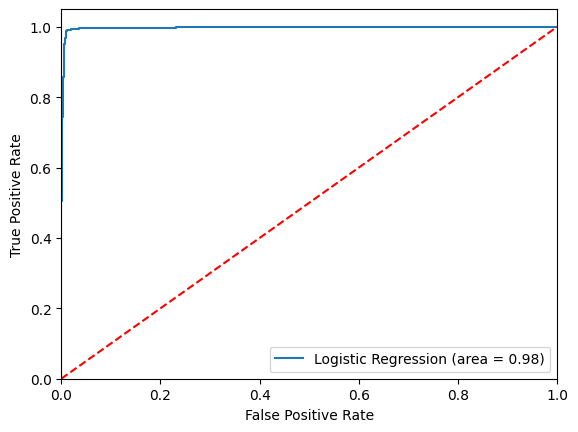


Desafio: 13
Accuracy: 0.966271
Precision: 0.853568
Recall: 0.998915
F1 score: 0.920540
AUC: 0.978624


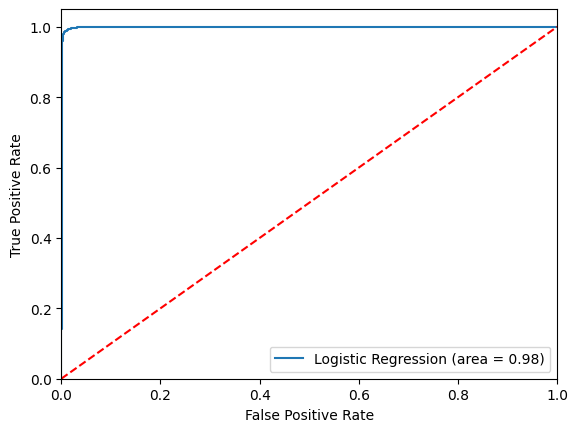


Desafio: 14
Accuracy: 0.991778
Precision: 0.937500
Recall: 0.997625
F1 score: 0.966628
AUC: 0.994305


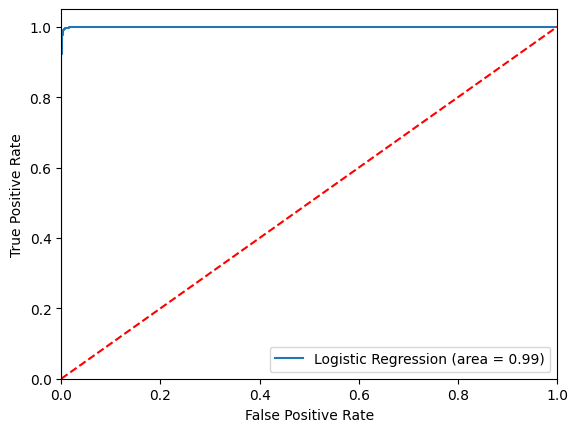


Desafio: 12
Accuracy: 0.933014
Precision: 0.661829
Recall: 0.989154
F1 score: 0.793043
AUC: 0.956899


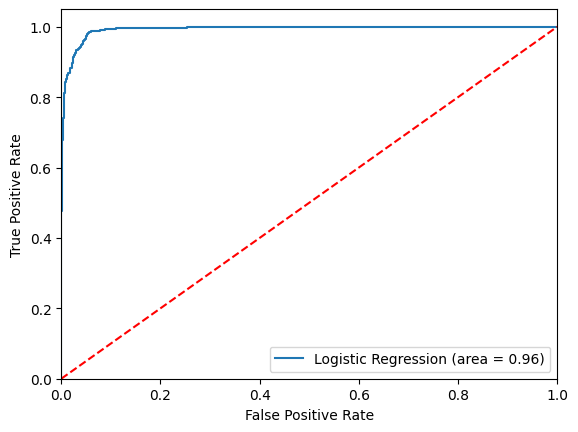


Desafio: 16
Accuracy: 0.961609
Precision: 0.804775
Recall: 0.987931
F1 score: 0.886997
AUC: 0.972402


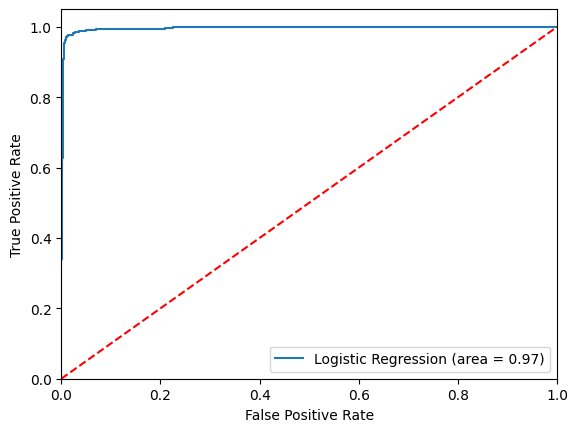


Desafio: 17
Accuracy: 0.949730
Precision: 0.676087
Recall: 1.000000
F1 score: 0.806744
AUC: 0.971919


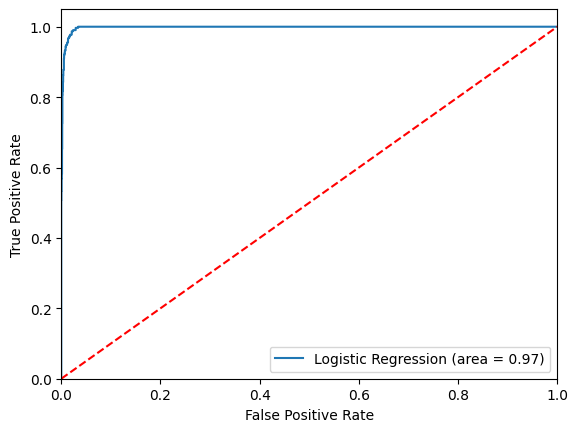


Desafio: 18
Accuracy: 0.929740
Precision: 0.633858
Recall: 0.990769
F1 score: 0.773109
AUC: 0.956061


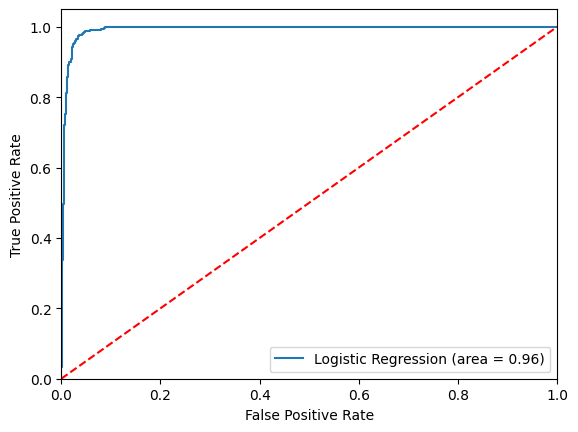

In [ ]:
for des in df.desafio.unique():
    
    print(f'\nDesafio: {des}')
    
    indices_des = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==des]['ID'].values]

    X_test_des = X_test.iloc[indices_des].drop('id_pairs', axis=1)

    y_test_des = [x for i,x in enumerate(y_test) if i in indices_des]
    
    y_pred = xgb_cls.predict(X_test_des)
    y_pred_proba = xgb_cls.predict_proba(X_test_des)
    print_performance(y_test_des, y_pred, y_pred_proba)

### Metrics Graphs

AUC 0.9732347142857142 0.956061 red
F1 score 0.8677742857142857 0.773109 red
Recall 0.9940817142857142 0.990769 red
Precision 0.7766534285714286 0.633858 red
Accuracy 0.958096 0.92974 red


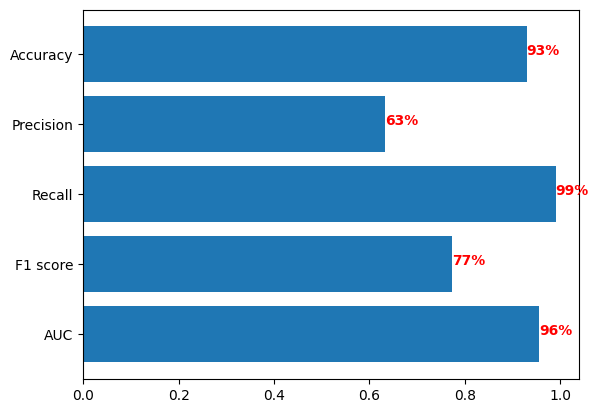

In [ ]:
metricas = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'][::-1]

valores_12 = [0.933014, 0.661829, 0.989154, 0.793043, 0.956899][::-1]
valores_13 = [0.966271, 0.853568, 0.998915, 0.920540, 0.978624][::-1]
valores_14 = [0.991778, 0.937500, 0.997625, 0.966628, 0.994305][::-1]
valores_15 = [0.974530, 0.868957, 0.994178, 0.927359, 0.982433][::-1]
valores_16 = [0.961609, 0.804775, 0.987931, 0.886997, 0.972402][::-1]
valores_17 = [0.949730, 0.676087, 1.000000, 0.806744, 0.971919][::-1]
valores_18 = [0.929740, 0.633858, 0.990769, 0.773109, 0.956061][::-1]

extra_trees = [0.914388, 0.634365, 0.973024, 0.768019, 0.938708][::-1]
general_xgboost = [0.960042, 0.787270, 0.994335, 0.878770, 0.974266][::-1]

# create horizontal bar plot
fig, ax = plt.subplots()
ax.barh(metricas, valores_18)

# add x value as label to each bar
for i, v in enumerate(valores_18):
    
    all_valores = valores_12[i]+valores_13[i]+valores_14[i]+valores_15[i]+valores_16[i]+valores_17[i]+valores_18[i]
    
    color = ['blue' if v >= all_valores/7 else 'red'][0]
    
    print(metricas[i],all_valores/7, v, color)
    
    ax.text(v, i, str(round(v*100))+'%', color=color, fontweight='bold')

plt.show()

# Conclusion

XGBoost is the best model with 94% acc

only 300 dimensions is an advantage for LSA